# Baseline: From OneR to Random Forests

## Imports

In [1]:
from fastai.imports import *


## Data Processing

Get the dataset appropriately whether we're in kaggle or not

In [2]:
import os
competition_name = "icr-identify-age-related-conditions"

is_kaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if is_kaggle:
    path = Path(f"/kaggle/input/{competition_name}")
else:
    import zipfile, kaggle
    path = Path.home() / '.kaggle' / 'input' / competition_name
    kaggle.api.competition_download_cli(competition_name, path=path.parent)
    zipfile.ZipFile(f'{path}.zip').extractall(path)

icr-identify-age-related-conditions.zip: Skipping, found more recently modified local copy (use --force to force download)


Load the datasets.

In [3]:
path.ls()

(#4) [Path('/home/krm/.kaggle/input/icr-identify-age-related-conditions/test.csv'),Path('/home/krm/.kaggle/input/icr-identify-age-related-conditions/greeks.csv'),Path('/home/krm/.kaggle/input/icr-identify-age-related-conditions/train.csv'),Path('/home/krm/.kaggle/input/icr-identify-age-related-conditions/sample_submission.csv')]

In [4]:
df_train = pd.read_csv(f'{path}/train.csv')
df_test = pd.read_csv(f'{path}/test.csv')
df_train.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


Identify null values.

In [5]:
df_train.isna().sum()

Id        0
AB        0
AF        0
AH        0
AM        0
AR        0
AX        0
AY        0
AZ        0
BC        0
BD        0
BN        0
BP        0
BQ       60
BR        0
BZ        0
CB        2
CC        3
CD        0
CF        0
CH        0
CL        0
CR        0
CS        0
CU        0
CW        0
DA        0
DE        0
DF        0
DH        0
DI        0
DL        0
DN        0
DU        1
DV        0
DY        0
EB        0
EE        0
EG        0
EH        0
EJ        0
EL       60
EP        0
EU        0
FC        1
FD        0
FE        0
FI        0
FL        1
FR        0
FS        2
GB        0
GE        0
GF        0
GH        0
GI        0
GL        1
Class     0
dtype: int64

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    object 
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AH      617 non-null    float64
 4   AM      617 non-null    float64
 5   AR      617 non-null    float64
 6   AX      617 non-null    float64
 7   AY      617 non-null    float64
 8   AZ      617 non-null    float64
 9   BC      617 non-null    float64
 10  BD      617 non-null    float64
 11  BN      617 non-null    float64
 12  BP      617 non-null    float64
 13  BQ      557 non-null    float64
 14  BR      617 non-null    float64
 15  BZ      617 non-null    float64
 16  CB      615 non-null    float64
 17  CC      614 non-null    float64
 18  CD      617 non-null    float64
 19  CF      617 non-null    float64
 20  CH      617 non-null    float64
 21  CL      617 non-null    float64
 22  CR

We'll only do simple data processing. We'll replace null values with modes, and convert EJ to a categorical columns

In [7]:
modes = df_train.mode().iloc[0]

In [8]:
def process_data(df):
    df.fillna(modes, inplace=True)
    df["EJ"] = pd.Categorical(df.EJ)
    
process_data(df_train)
process_data(df_test)

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Id      617 non-null    object  
 1   AB      617 non-null    float64 
 2   AF      617 non-null    float64 
 3   AH      617 non-null    float64 
 4   AM      617 non-null    float64 
 5   AR      617 non-null    float64 
 6   AX      617 non-null    float64 
 7   AY      617 non-null    float64 
 8   AZ      617 non-null    float64 
 9   BC      617 non-null    float64 
 10  BD      617 non-null    float64 
 11  BN      617 non-null    float64 
 12  BP      617 non-null    float64 
 13  BQ      617 non-null    float64 
 14  BR      617 non-null    float64 
 15  BZ      617 non-null    float64 
 16  CB      617 non-null    float64 
 17  CC      617 non-null    float64 
 18  CD      617 non-null    float64 
 19  CF      617 non-null    float64 
 20  CH      617 non-null    float64 
 21  CL      617 non-

In [10]:
df_train.EJ.cat.codes.head()

0    1
1    0
2    1
3    1
4    1
dtype: int8

Separately identify the categorical, numeric and dependent variables

In [11]:
categoricals = ["EJ"]
dependent = "Class"
conts = [column for column in df_train.columns if not column in categoricals + [dependent] + ["Id"]]

In [12]:
len(conts)

55

## Binary Splits

A decision tree is build on binary splits, so we start by splitting on categorical column `EJ` just to see what results it gives us. We use seaborn to compare see how splitting on EJ relates to the outcome (diagnosed to have one of the age-related conditions).

[Text(0.5, 1.0, 'Histogram')]

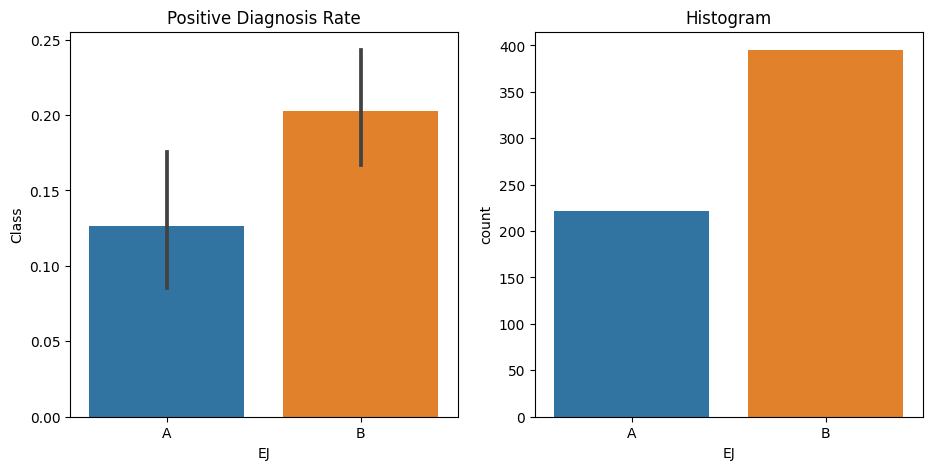

In [13]:
import seaborn as sns

fig, axs = plt.subplots(1, 2, figsize=(11, 5))
sns.barplot(data=df_train, y=dependent, x="EJ", ax=axs[0]).set(title="Positive Diagnosis Rate")
sns.countplot(data=df_train, x="EJ", ax=axs[1]).set(title="Histogram")

We have a higher positivity rate for category B (~ 20%) than category A (~ 3%). We also have much higher proportion of observations with category B (~ 400) than category A (~ 230). This correlation could in part explain why B has a higher positivity rate.

We can also do a split based on a continuous column. Since these columns are anonymized, we'll go with column `AB` just for demonstration. We use a boxplot to compare the averages of both positive and negative diagnosis based on the trait `AB` and a density plot to visualize the distribution of observations on `AB`.

<Axes: xlabel='AB', ylabel='Density'>

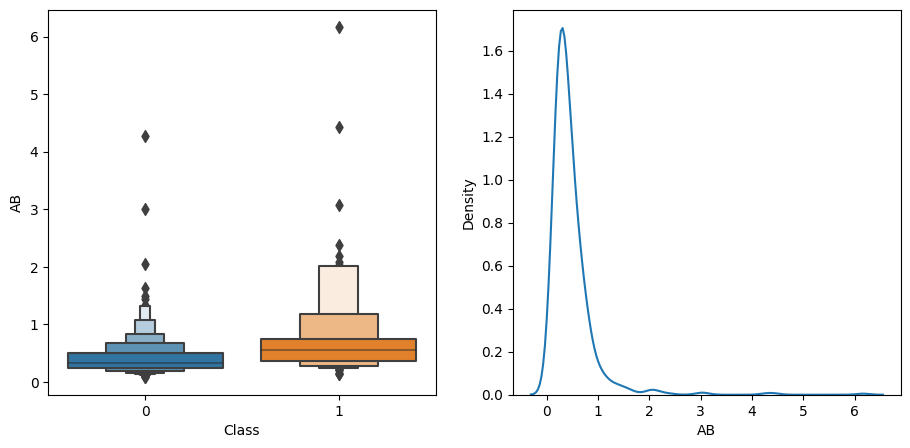

In [14]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(11, 5))
sns.boxenplot(data=df_train, x=dependent, y="AB", ax=ax1)
sns.kdeplot(data=df_train, x="AB", ax=ax2)

What we see is that the observations that result in a positive diagnosis have a slightly higher average of value `AB` than those that don't. We also notice that there some outliers with higher values for `AB`. It is difficult to determine the value of `AB` that best splits between the two classes though, since most of the observations are between 0 and 1 for `AB`, although the average value of negative diagnosis (class 0) appears below 0.5.

Since we have quite a number of columns, it would be tedious to plot each of them and figure out how well it partitions between positive and negative diagnosis, and which value of that column gives the best split.

We can however create a function that will help us quickly evaluate different splits by calculating a measure of impurity of how a split divides the observations into 2 groups, i.e. how similar or dissimilar they are with respect to the dependent variable.

We measure similarity by calculating the standard deviation of the dependent variable within each group of the split. The lower it is, they more similar the observations in each group are. We multiply this by the number of observations in each group since the bigger the group, they more weight it has.

We calculate the score of a split by summing the scores of the left side and the right side of that split using a particular value of that column.

In [15]:
def score(col, y, split_value):
    lhs = col <= split_value
    return (_side_score(lhs, y) + _side_score(~lhs, y))/len(y)

def _side_score(side, y):
    count = side.sum()
    if count <=1: return 0
    return y[side].std() * count

For instance, the score based on value 0.5 for columns `AB`:

In [16]:
score(df_train.AB, df_train[dependent], 0.5)

0.36017711175753037

For the categorical column, we'd need to replace the column string values with their underlying codes, since we're calculating scores using numeric values.


In [17]:
df_train_n = df_train.copy()
df_train_n[categoricals] = df_train_n[categoricals].apply(lambda x: x.cat.codes)
df_train_n[categoricals].head()

,EJ
0,1
1,0
2,1
3,1
4,1


We then calculate the score using <= 1 as our split

In [18]:
score(df_train_n.EJ, df_train_n[dependent], 1)

0.3803100751041243

Looks like the split on the categorical fares a bit worse than that of column `AB` at 0.5

To help us find the best split point, we'll iterate through the columns, and for each, we iterate through it's unique values to find the best split point for the column.

For example to find the best split point for column `AB`:

In [19]:
col = df_train_n["AB"]
y = df_train_n[dependent]
uniques = col.unique()
uniques.sort()
uniques[:50]

array([0.081187 , 0.08546  , 0.098279 , 0.102552 , 0.111098 , 0.119644 ,
       0.1217805, 0.1303265, 0.132463 , 0.136736 , 0.141009 , 0.145282 ,
       0.149555 , 0.153828 , 0.1559645, 0.158101 , 0.1602375, 0.162374 ,
       0.166647 , 0.17092  , 0.175193 , 0.179466 , 0.183739 , 0.1858755,
       0.188012 , 0.1901485, 0.192285 , 0.196558 , 0.200831 , 0.2029675,
       0.205104 , 0.209377 , 0.21365  , 0.217923 , 0.222196 , 0.2243325,
       0.226469 , 0.230742 , 0.235015 , 0.239288 , 0.243561 , 0.247834 ,
       0.252107 , 0.25638  , 0.260653 , 0.2627895, 0.264926 , 0.269199 ,
       0.2713355, 0.273472 ])

In [20]:
scores = np.array([score(col, y, split) for split in uniques])
uniques[scores.argmin()]

0.410208

This tells us that the value of `AB` that gives the best split is 0.410208.

We can implement this idea to calculate the best split point for any given column.

In [21]:
def min_column(df, col_name):
    col, y = df[col_name], df[dependent]
    uniques = col.unique()
    scores = np.array([score(col, y, split) for split in uniques])
    index = scores.argmin()
    return uniques[index], scores[index]

In [22]:
min_column(df_train_n, "AB")

(0.410208, 0.3561906829723693)

We can try the same thing for the categorical variable:

In [23]:
min_column(df_train_n, "EJ")

(0, 0.3773339803468088)

Turns out having all observations on one side gives a better score when looking at the categorical column alone.

We can then calculate the best split points for each column to find the best split overall.

In [24]:
columns = conts + categoricals
splits = {col: min_column(df_train_n, col) for col in columns}

In [25]:
splits

{'AB': (0.410208, 0.3561906829723693),
 'AF': (2808.64232, 0.35583548065304915),
 'AH': (193.801377, 0.3761985927636321),
 'AM': (149.318758, 0.367338331639673),
 'AR': (16.327194, 0.3678281215243884),
 'AX': (17.877462, 0.37677322461475915),
 'AY': (0.6019965, 0.37677322461475915),
 'AZ': (10.971782, 0.3782810033906922),
 'BC': (13.500788, 0.35968813799570454),
 'BD ': (12083.34891, 0.3749922782916859),
 'BN': (21.186, 0.3651185274145938),
 'BP': (196.710795, 0.3725348222558456),
 'BQ': (115.695865, 0.3668876611761174),
 'BR': (3466.745415, 0.374094640781585),
 'BZ': (2885.319798, 0.376211243844383),
 'CB': (13.32695, 0.37775055805021784),
 'CC': (0.5478777, 0.3665150807004323),
 'CD ': (85.955376, 0.3635292346687648),
 'CF': (1.8504485, 0.367406050093466),
 'CH': (0.016318, 0.3782672405025747),
 'CL': (1.24754, 0.37657306471010377),
 'CR': (0.527325, 0.35228611051878406),
 'CS': (62.2516675, 0.37277362672289577),
 'CU': (1.274427, 0.37534114864714596),
 'CW ': (35.67944, 0.3772898765

In [26]:
min_score = 1
for k, v in splits.items():
    if v[1] < min_score:
        min_score = v[1]
        min_score_column = k
min_score_column, splits[min_score_column]        

('DU', (2.27601, 0.3207517917154871))

According to this, the column `DU` gives the best score at split point `2.27601` overall. We can make a simple model based off this approach. This will be a variant of what is called the [OneR](https://link.springer.com/article/10.1023/A:1022631118932) classifier.

In [27]:
from numpy import random
from sklearn.model_selection import train_test_split

random.seed(42)
model_train, model_val = train_test_split(df_train_n,  test_size=0.25)

In [28]:
model_train.shape, model_val.shape

((462, 58), (155, 58))

We split each of training and validation sets to independent and dependent variables.

In [29]:
def x_y(df):
    return df[conts + categoricals], df[dependent]

model_train_x, model_train_y = x_y(model_train)
model_val_x, model_val_y = x_y(model_val)

We get the best split using the OneR training set.

In [30]:
one_r_splits = {col: min_column(model_train, col) for col in model_train_x.columns}
one_r_splits

{'AB': (0.581128, 0.3500151266645586),
 'AF': (2807.2121, 0.3482960305933906),
 'AH': (196.117971, 0.37031622929971825),
 'AM': (113.124119, 0.3677805771621117),
 'AR': (15.870966, 0.36607803019531715),
 'AX': (17.877462, 0.3701715230565572),
 'AY': (0.038976, 0.372511904676532),
 'AZ': (23.626198, 0.3735437010139049),
 'BC': (13.500788, 0.35865783745331065),
 'BD ': (10563.27538, 0.37017152305655715),
 'BN': (20.8329, 0.36082123208699335),
 'BP': (282.245337, 0.36079488319104713),
 'BQ': (69.65249, 0.36180119785038894),
 'BR': (5161.327397, 0.36527011004085347),
 'BZ': (2885.319798, 0.36963503519601426),
 'CB': (12.931737, 0.37244503925274197),
 'CC': (0.61375644, 0.3617285103240913),
 'CD ': (85.68186, 0.3631411826566342),
 'CF': (1.8504485, 0.36160897217069404),
 'CH': (0.012338, 0.3725637613110524),
 'CL': (1.24754, 0.3725459888575431),
 'CR': (0.527325, 0.34941117879168376),
 'CS': (62.2516675, 0.3671272819598272),
 'CU': (1.125468, 0.366462462615929),
 'CW ': (35.67944, 0.3672847

In [31]:
def get_best_split(splits):
    min_score = 1
    for k, v in splits.items():
        if v[1] < min_score:
            min_score = v[1]
            min_score_column = k
    return min_score_column, splits[min_score_column]

column, split = get_best_split(one_r_splits)
column, split

('DU', (2.262216, 0.3196074664465314))

According to this, `DU` still remains the best split at split point `2.262216`. We then use this as a simple model One R  and make predictions for the validation set.

In [32]:
preds = model_val_x["DU"] <= 2.262216

From this we can calculate the mean absolute error to help us evaluate the model and set a baseline.

In [33]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(model_val_y, preds)

0.864516129032258

The error is relatively large suggesting that this baseline model is very inaccurate, meaning One R is works poorly for this data.

This when submitted to the competition it had a leaderboard score of 25.97 and was among the bottom scores.

## Decision Tree

After having identified the best split for the training set we can split the data into two groups, then for each group, find the next best split.

We can split our training data into two groups based on the value of `DU` we identified above then find the best successive splits.

In [34]:
lhs = model_train["DU"] <= 2.262216
left_group = model_train[lhs]
right_group = model_train[~lhs]
left_group.shape, right_group.shape

((396, 58), (66, 58))

Next, we find the best splits for each group while excluding the `DU` column.

In [35]:
second_level_columns = [c for c in (conts + categoricals) if c != "DU"]
left_splits = {col: min_column(left_group, col) for col in second_level_columns}
right_splits = {col: min_column(right_group, col) for col in second_level_columns}
left_splits, right_splits

({'AB': (0.363205, 0.2205227532918278),
  'AF': (1744.8442, 0.26422367520400314),
  'AH': (186.276801, 0.28281828339030296),
  'AM': (16.333578, 0.2678889313583875),
  'AR': (15.870966, 0.2866140712941824),
  'AX': (5.244528, 0.2773853964685262),
  'AY': (0.6019965, 0.2874443162878375),
  'AZ': (8.186298, 0.2851965412728709),
  'BC': (13.500788, 0.254228411937528),
  'BD ': (10563.27538, 0.28342483094474047),
  'BN': (15.1833, 0.2815221656802702),
  'BP': (318.7728, 0.27010283692431253),
  'BQ': (11.865775, 0.2794184862139197),
  'BR': (5161.327397, 0.2752096532354187),
  'BZ': (1703.832302, 0.28396363710150363),
  'CB': (12.931737, 0.28032816063022753),
  'CC': (0.61375644, 0.2699890428677908),
  'CD ': (88.048368, 0.2693262549530457),
  'CF': (2.548358, 0.27644641567153155),
  'CH': (0.016716, 0.2836102268644721),
  'CL': (1.152065, 0.2817474069769845),
  'CR': (0.6729, 0.25077109773069917),
  'CS': (55.8007175, 0.2831938474420979),
  'CU': (1.059264, 0.2763697098465586),
  'CW ': (4

In [36]:
best_left_split = get_best_split(left_splits)
best_right_split = get_best_split(right_splits)
best_left_split, best_right_split

(('AB', (0.363205, 0.2205227532918278)),
 ('GL', (0.047863636, 0.40470758822889663)))

For our left group, column `AB` results in the best split and `GL` for the right group.

Combining the three splitting rules by first splitting by `DU`, then the left group by `AB` and the right by `GL` results in a decision tree. Rather than rolling it out by hand, we can use sklearn's built in Decision Tree classifier.

In [37]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

model = DecisionTreeClassifier(max_leaf_nodes=4).fit(model_train_x, model_train_y)

We can write a procedure to visualize the created tree.

In [38]:
import graphviz

def draw_tree(tree, df, size=10, ratio=0.6, precision=2, **kwargs):
    dot_format = export_graphviz(tree, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                                special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', dot_format))

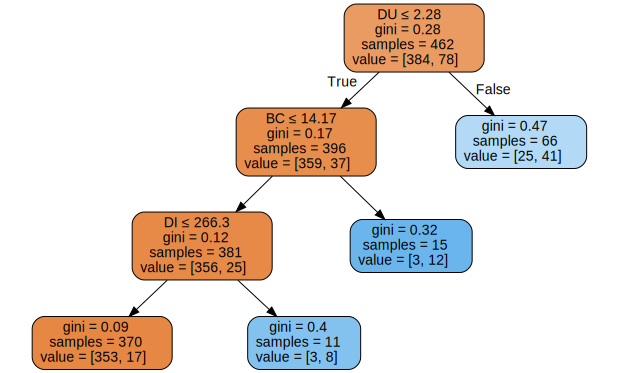

In [39]:
draw_tree(model, model_train_x, size=10)

The decision tree uses a measure of impurity called the gini index. This measures the probability that if one picks two observations from a group, they will not have the same value for the dependent column, i.e. the `Class` in our case. Therefore in the case of perfect classification, where all observations in the group have the same value for `Class`, the gini index is zero. The more impure the group is, the higher the gini index.

It is determined by subtracting the sum of squared probabilities of each class of the prediction from 1, and can be implemented as follows.

In [40]:
def gini(df, condition):
    actual = df.loc[condition, dependent]
    return 1 - actual.mean()**2 - (1-actual).mean()**2

We can replicate the split at the root of the tree above like so:

In [41]:
gini(model_train, model_train['DU'] <= 2.28), gini(model_train, model_train['DU'] > 2.28)

(0.16940873380267307, 0.47061524334251614)

Like with our OneR approach, the decision tree starts with a split on `DU` as the best split, thought it uses a different value for the split. Subsequent splits are different from what we got when we tried it by hand.

The non-leaf nodes show which column was used for the split and at what value, the gini score, the number of observations in that group prior to the split as `samples` and `value` hints at the purity of that group, showing how it is partitioned by the dependent variable.

We can calculate the mean absolute error of this decision tree:

In [42]:
mean_absolute_error(model_val_y, model.predict(model_val_x))

0.11612903225806452

We see that just two additional splits have increased the accuracy on the training data considerably. We can create a bigger tree to see whether it will minimise the error further.

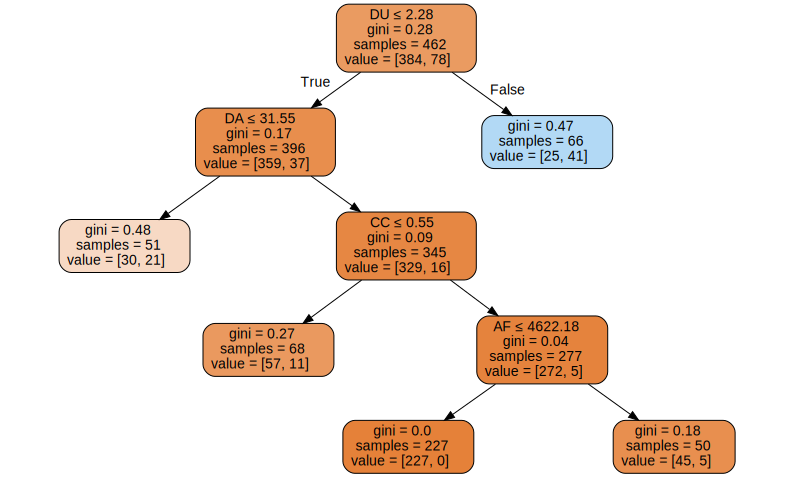

In [43]:
model = DecisionTreeClassifier(min_samples_leaf=50)
model.fit(model_train_x, model_train_y)
draw_tree(model, model_train_x, size=12)

By allowing the tree to have a greater number of leaf nodes, we've allowed it to reach a grouping with a gini score of zero, which is a perfect classification. However, the larger a decision tree is, the more it tends to overfit the training data and may not generalize well to the test data. 

We can see what MAE of this tree is:

In [44]:
mean_absolute_error(model_val_y, model.predict(model_val_x))

0.12903225806451613

We find that it has a slightly higher error than the smaller tree maybe hinting at overfitting. When submitted to the competition, it had a score of 1.72 on the public leaderboard, an improvement over 25.97 of the OneR model.

## Random Forests

As mentioned, making the decision tree bigger will result in making it match the training data more closely, resulting in overfitting.

Instead of using bigger trees, we can use more trees. That's the insight from Leo Breiman who helped formulate the technique. By training more trees, each trained on a random uncorrelated subset of the training data and averaging their results, we get a better result because the average of uncorrelated errors is close to zero meaning the prediction is close to the true value.

To demonstrate the technique, we can train a tree on a random subset of the data by:

In [52]:
def get_tree(proportion=0.75):
    n = len(model_train_y)
    indexes = random.choice(n, int(n*proportion))
    return DecisionTreeClassifier(min_samples_leaf=5).fit(model_train_x.iloc[indexes], model_train_y.iloc[indexes])   

Now we can train as many trees as needed and average their results.

In [53]:
trees = [get_tree() for _ in range(100)]
trees[:5]

[DecisionTreeClassifier(min_samples_leaf=5),
 DecisionTreeClassifier(min_samples_leaf=5),
 DecisionTreeClassifier(min_samples_leaf=5),
 DecisionTreeClassifier(min_samples_leaf=5),
 DecisionTreeClassifier(min_samples_leaf=5)]

In [54]:
all_preds = [t.predict(model_val_x) for t in trees]
avg_preds = np.stack(all_preds).mean(axis=0)

In [55]:
mean_absolute_error(model_val_y, avg_preds)

0.15941935483870967

`sklearn`'s `RandomForestClassifier` does a similar process, but in addition to selecting a random subset of rows, it also selects a random subset of columns.

In [57]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, min_samples_leaf=5)
rf.fit(model_train_x, model_train_y)
mean_absolute_error(model_val_y, rf.predict(model_val_x))

0.05806451612903226